# Random Forest Classifier

In [1]:
# Import dependencies
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
# Import data
US_wine_data_df = pd.read_csv("Data/US_wine_data.csv")
print(US_wine_data_df.shape)
US_wine_data_df.head()

(54265, 9)


,description,points,price,province,region_1,region_2,title,variety,winery
0,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
1,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
2,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
3,"Soft, supple plum envelopes an oaky structure ...",87,19.0,California,Napa Valley,Napa,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
4,"Slightly reduced, this wine offers a chalky, t...",87,34.0,California,Alexander Valley,Sonoma,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini


In [3]:
# Make a copy of the dataframe
US_wine_data_df_copy = US_wine_data_df
US_wine_data_df_copy.shape

(54265, 9)

## Pre process for machine learning

In [4]:
# Group wine price into bins.
price_counts = US_wine_data_df.price.value_counts()
price_counts

25.0     2860
20.0     2736
30.0     2613
35.0     2240
40.0     2157
         ... 
138.0       1
400.0       1
147.0       1
104.0       1
117.0       1
Name: price, Length: 160, dtype: int64

<AxesSubplot:ylabel='Density'>

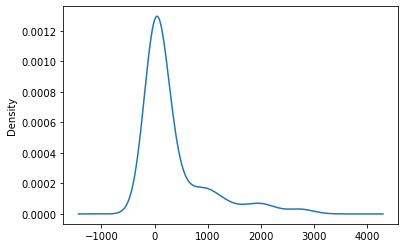

In [5]:
price_counts.plot.density()

In [6]:
# Create price bins
price_bins = [0, 15, 30, 60, 100, 500, 5000]
US_wine_data_df.groupby(pd.cut(US_wine_data_df["price"], price_bins)).count()

price_bins_names = ["<$15","$15-30","$30-60","$60-100", "100-500","too much"]

# Make a new column in dataframe for price bins.
US_wine_data_df["price_bins"] = pd.cut(US_wine_data_df["price"], price_bins, labels=price_bins_names)

# Check dataframe
US_wine_data_df.tail()

,description,points,price,province,region_1,region_2,title,variety,winery,price_bins
54260,Hailing from one of the more popular vineyards...,90,20.0,California,Santa Ynez Valley,Central Coast,Birichino 2013 Jurassic Park Vineyard Old Vine...,Chenin Blanc,Birichino,$15-30
54261,There's no bones about the use of oak in this ...,90,35.0,California,Napa Valley,Napa,Flora Springs 2013 Barrel Fermented Chardonnay...,Chardonnay,Flora Springs,$30-60
54262,This opens with herbaceous dollops of thyme an...,90,35.0,California,Napa Valley,Napa,Hendry 2012 Blocks 7 & 22 Zinfandel (Napa Valley),Zinfandel,Hendry,$30-60
54263,This Zinfandel from the eastern section of Nap...,90,22.0,California,Chiles Valley,Napa,Houdini 2011 Zinfandel (Chiles Valley),Zinfandel,Houdini,$15-30
54264,Citation is given as much as a decade of bottl...,90,75.0,Oregon,Oregon,Oregon Other,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,$60-100


In [7]:
# Create a DataFrame to hold columns ("description", "price", "province", "region_2", "title", "winery")
# that won't be used in machine learning in case we want them later.
US_wine_data_title_df = US_wine_data_df.drop(columns=["points", "region_1", "variety","price_bins"], axis=1)
print(US_wine_data_title_df.shape)
US_wine_data_title_df.head()

(54265, 6)


,description,price,province,region_2,title,winery
0,"Tart and snappy, the flavors of lime flesh and...",14.0,Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Rainstorm
1,"Pineapple rind, lemon pith and orange blossom ...",13.0,Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,St. Julian
2,"Much like the regular bottling from 2012, this...",65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Sweet Cheeks
3,"Soft, supple plum envelopes an oaky structure ...",19.0,California,Napa,Kirkland Signature 2011 Mountain Cuvée Caberne...,Kirkland Signature
4,"Slightly reduced, this wine offers a chalky, t...",34.0,California,Sonoma,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Louis M. Martini


In [8]:
# Save cleaned columns ("description", "price", "province", "region_2", "title", "winery")
# in case we want to load into database later.
US_wine_data_title_df.to_csv("Data/US_wine_data_title.csv", index=False)

In [9]:
# Create DataFrame for machine learning model. Drop: "description" - of flavors, i.e. tart and snappy, 
# oaky, etc., price, province, region_2, "title" - name on the bottle, winery.

US_wine_data_df_ml = US_wine_data_df.drop(columns=["description", "price", "province", "region_2", "title", "winery"], axis=1)
print(US_wine_data_df_ml.shape)
US_wine_data_df_ml.head()

(54265, 4)


,points,region_1,variety,price_bins
0,87,Willamette Valley,Pinot Gris,<$15
1,87,Lake Michigan Shore,Riesling,<$15
2,87,Willamette Valley,Pinot Noir,$60-100
3,87,Napa Valley,Cabernet Sauvignon,$15-30
4,87,Alexander Valley,Cabernet Sauvignon,$30-60


In [10]:
# Save preprocessed dataframe (columns for machine learning: "points","region_1",""variety","price_bins")
US_wine_data_df_ml.to_csv("Data/US_wine_data_ml.csv", index=False)

### Checkpoint

In [11]:
# Import data
US_wine_data_df_ml = pd.read_csv("Data/US_wine_data_ml.csv")
print(US_wine_data_df_ml.shape)
US_wine_data_df_ml.head()

(54265, 4)


,points,region_1,variety,price_bins
0,87,Willamette Valley,Pinot Gris,<$15
1,87,Lake Michigan Shore,Riesling,<$15
2,87,Willamette Valley,Pinot Noir,$60-100
3,87,Napa Valley,Cabernet Sauvignon,$15-30
4,87,Alexander Valley,Cabernet Sauvignon,$30-60


In [12]:
# Look at unique values to see if categorical data requires binning
US_wine_data_df_ml.nunique()

points         21
region_1      266
variety       257
price_bins      6
dtype: int64

In [13]:
# Determine value_counts for binning
variety_counts = US_wine_data_df_ml.variety.value_counts()
variety_counts

Pinot Noir            9857
Cabernet Sauvignon    7280
Chardonnay            6773
Syrah                 3232
Red Blend             2948
                      ... 
Sangiovese Grosso        1
Greco                    1
Tinta Amarela            1
Garnacha Blanca          1
Moscato Giallo           1
Name: variety, Length: 257, dtype: int64

<AxesSubplot:ylabel='Density'>

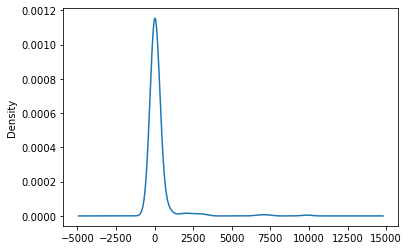

In [14]:
# Visualize the value counts of variety
variety_counts.plot.density()

In [15]:
# Determine which values to replace.  Per the plot, we tried <500 but after looking
# results we decided that we wanted to be more inclusive since some mainstream wines
# would be binned in "other".  Therefore we lowered the threshold for other to 300.
replace_variety = list(variety_counts[variety_counts <= 300].index)

# Replace in dataframe
for variety in replace_variety:
    US_wine_data_df_ml.variety = US_wine_data_df_ml.variety.replace(variety,"Other")
    
# Check to make sure binning was successful
US_wine_data_df_ml.variety.value_counts()

Pinot Noir                  9857
Cabernet Sauvignon          7280
Chardonnay                  6773
Other                       4569
Syrah                       3232
Red Blend                   2948
Zinfandel                   2705
Merlot                      2300
Sauvignon Blanc             2154
Bordeaux-style Red Blend    1817
Riesling                    1745
Cabernet Franc               999
Rosé                         900
Pinot Gris                   863
Viognier                     786
Petite Sirah                 745
Rhône-style Red Blend        690
Sparkling Blend              678
White Blend                  634
Malbec                       533
Grenache                     520
Sangiovese                   429
Gewürztraminer               405
Pinot Grigio                 360
Tempranillo                  343
Name: variety, dtype: int64

In [16]:
# Determine value_counts for binning
region_1_counts = US_wine_data_df_ml.region_1.value_counts()
region_1_counts

Napa Valley                       4475
Columbia Valley (WA)              4109
Russian River Valley              3090
California                        2629
Paso Robles                       2327
                                  ... 
Lake-Sonoma-Napa                     1
Sonoma-Santa Barbara-Mendocino       1
Sonoma-Napa-Mendocino                1
Isle St. George                      1
Tehama County                        1
Name: region_1, Length: 266, dtype: int64

<AxesSubplot:ylabel='Density'>

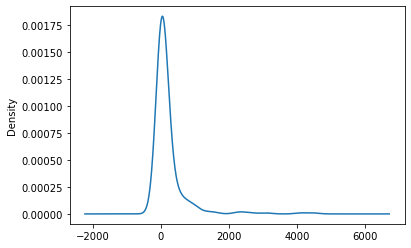

In [17]:
# Visualize the value counts of region_1
region_1_counts.plot.density()

In [18]:
# From the plot the curve breaks around 500.
replace_region_1 = list(region_1_counts[region_1_counts <= 300].index)

# Replace in dataframe
for region_1 in replace_region_1:
    US_wine_data_df_ml.region_1 = US_wine_data_df_ml.region_1.replace(region_1,"Other")
    
# Check to make sure binning was successful
US_wine_data_df_ml.region_1.value_counts()

Other                        9568
Napa Valley                  4475
Columbia Valley (WA)         4109
Russian River Valley         3090
California                   2629
Paso Robles                  2327
Willamette Valley            2296
Finger Lakes                 1556
Sonoma Coast                 1467
Sonoma County                1245
Walla Walla Valley (WA)      1061
Carneros                      999
Santa Barbara County          994
Yakima Valley                 984
Sta. Rita Hills               971
Dry Creek Valley              936
Santa Ynez Valley             806
Santa Lucia Highlands         802
Lodi                          799
Alexander Valley              780
Central Coast                 737
Red Mountain                  719
Santa Maria Valley            701
Sonoma Valley                 660
Anderson Valley               646
North Fork of Long Island     596
Dundee Hills                  554
Horse Heaven Hills            554
Virginia                      552
Santa Cruz Mou

### Encode categorical data

In [19]:
# Create variable to hold categorical columns for OneHotEncoder
wine_cat = ["variety", "region_1"]

In [20]:
# from sklearn.preprocessing import OneHotEncoder
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(US_wine_data_df_ml[wine_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(wine_cat)
encode_df.shape
encode_df.head()

,variety_Bordeaux-style Red Blend,variety_Cabernet Franc,variety_Cabernet Sauvignon,variety_Chardonnay,variety_Gewürztraminer,variety_Grenache,variety_Malbec,variety_Merlot,variety_Other,variety_Petite Sirah,...,region_1_Sonoma Coast,region_1_Sonoma County,region_1_Sonoma Valley,region_1_Sta. Rita Hills,region_1_Virginia,region_1_Wahluke Slope,region_1_Walla Walla Valley (WA),region_1_Washington,region_1_Willamette Valley,region_1_Yakima Valley
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Merge one-hot encoded features and drop the originals
US_wine_data_df_ml = US_wine_data_df_ml.merge(encode_df,left_index=True, right_index=True)
US_wine_data_df_ml = US_wine_data_df_ml.drop(wine_cat,axis=1)
print(US_wine_data_df_ml.shape)
US_wine_data_df_ml.head()

(54265, 73)


,points,price_bins,variety_Bordeaux-style Red Blend,variety_Cabernet Franc,variety_Cabernet Sauvignon,variety_Chardonnay,variety_Gewürztraminer,variety_Grenache,variety_Malbec,variety_Merlot,...,region_1_Sonoma Coast,region_1_Sonoma County,region_1_Sonoma Valley,region_1_Sta. Rita Hills,region_1_Virginia,region_1_Wahluke Slope,region_1_Walla Walla Valley (WA),region_1_Washington,region_1_Willamette Valley,region_1_Yakima Valley
0,87,<$15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,87,<$15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,87,$60-100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,87,$15-30,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,87,$30-60,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Save preprocessed dataframe to csv for future reference.
US_wine_data_df_ml.to_csv("Data/US_wine_data_enc.csv", index=False)

In [23]:
# Import data
US_wine_data_df_ml = pd.read_csv("Data/US_wine_data_enc.csv")

### Split preprocessed data 

In [24]:
# from sklearn.model_selection import train_test_split
# Split preprocessed data into our features and target arrays
#  Target
y = US_wine_data_df_ml["price_bins"].values
# Features
X = US_wine_data_df_ml.drop(["price_bins"],axis=1).values

In [25]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [26]:
# from sklearn.preprocessing import StandardScaler
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [27]:
print(X_train_scaled [0:5])

[[ 1.7447257  -0.18748622 -0.13627336 -0.39263251 -0.37863285 -0.08675177
  -0.09669522 -0.10100397 -0.2118444  -0.30298795 -0.11693615 -0.07971786
  -0.12407186  2.12635075 -0.24094144 -0.1137647  -0.18114385 -0.12878626
  -0.08646379 -0.2036718  -0.11332066 -0.25468221 -0.07734215 -0.12294403
  -0.1119785  -0.22727754 -0.12107719 -0.08617488 -0.10738964 -0.22475533
  -0.13701973 -0.11801104 -0.08002942 -0.28744384 -0.13305798 -0.10100397
  -0.08559422 -0.07456046 -0.17204439 -0.10075542 -0.08958218 -0.12139021
  -0.08156985 -0.08486296 -0.0794051  -0.07877596 -0.30231076 -0.08187454
  -0.10633115 -0.09232853 -0.46208804 -0.21006536 -0.11519662 -0.08456874
   4.05794933 -0.08617488 -0.13877747 -0.10087977 -0.12284102 -0.11332066
  -0.12294403 -0.08703883 -0.16674872 -0.15384664 -0.11141474 -0.13467458
  -0.1016228  -0.08018476 -0.14178246 -0.08972143 -0.20750193 -0.13636686]
 [ 1.42378935 -0.18748622 -0.13627336 -0.39263251 -0.37863285 -0.08675177
  10.34177232 -0.10100397 -0.2118444 

## Machine Learning

### Try RandomForestClassifier

In [28]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
# Create a random forest classifier. 
rf_model = RandomForestClassifier(n_estimators=500, random_state=1) 

In [29]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [30]:
# Making predictions using the testing data.
y_pred = rf_model.predict(X_test_scaled)

In [31]:
# Display the confustion matrix
# from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[3612, 1330,   36,    0,  400,    0],
       [1385, 3398,  213,   18,   51,    0],
       [ 122,  738,  278,   37,    2,    0],
       [  12,   83,  127,   50,    0,    2],
       [ 754,   76,    1,    0,  840,    0],
       [   0,    0,    0,    2,    0,    0]], dtype=int64)

In [32]:
# Calculate the accuracy score
# from sklearn.metrics import accuracy_score, classification_report
acc_score = accuracy_score(y_test, y_pred)

In [33]:
# Displaying results
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, y_pred))

Accuracy Score : 0.6027861723299182
Classification Report
              precision    recall  f1-score   support

      $15-30       0.61      0.67      0.64      5378
      $30-60       0.60      0.67      0.64      5065
     $60-100       0.42      0.24      0.30      1177
     100-500       0.47      0.18      0.26       274
        <$15       0.65      0.50      0.57      1671
    too much       0.00      0.00      0.00         2

    accuracy                           0.60     13567
   macro avg       0.46      0.38      0.40     13567
weighted avg       0.60      0.60      0.59     13567

